In [129]:
import statistics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from nltk.metrics import ConfusionMatrix

In [20]:
annotations = pd.read_csv('../generate-tr/annotations.csv', skiprows=4)

In [74]:
session_to_rate_scores = defaultdict(list)
for session, rate_score in zip(annotations.Session, annotations['11']):
    if session != session or rate_score != rate_score:
        continue
    session_str = int(session)
    session_to_rate_scores[session_str].append(rate_score)

In [75]:
print('Number of rate=1 annotations:', sum([rate_scores.count(1) for session, rate_scores in session_to_rate_scores.items()]))
print('Number of rate=2 annotations:', sum([rate_scores.count(2) for session, rate_scores in session_to_rate_scores.items()]))
print('Number of rate=3 annotations:', sum([rate_scores.count(3) for session, rate_scores in session_to_rate_scores.items()]))

Number of rate=1 annotations: 1636
Number of rate=2 annotations: 4991
Number of rate=3 annotations: 616


In [76]:
print('Number of sessions:', len(session_to_rate_scores.keys()))

Number of sessions: 1202


In [84]:
rate_matrix = pd.DataFrame(session_to_rate_scores.keys()).rename(columns={0: 'Session'})
rate_matrix['contains_3'] = rate_matrix.Session.apply(lambda session: 3 in session_to_rate_scores[session])
rate_matrix['average_rate'] = rate_matrix.Session.apply(lambda session: statistics.mean(session_to_rate_scores[session]))
rate_matrix['most_common_rate'] = rate_matrix.Session.apply(lambda session: Counter(session_to_rate_scores[session]).most_common()[0][0])

# rate_matrix = rate_matrix.sample(frac=1).reset_index(drop=True)
rate_matrix = rate_matrix.sort_values(by=['Session']).reset_index(drop=True).set_index('Session')
rate_matrix

contains_3  average_rate  most_common_rate
Session                                            
13107         False      1.666667               2.0
13111         False      1.500000               2.0
13112         False      1.400000               1.0
13113         False      1.166667               1.0
13116         False      1.600000               2.0
...             ...           ...               ...
53803         False      2.000000               2.0
53945         False      2.000000               2.0
54096         False      2.000000               2.0
54166         False      2.000000               2.0
54195          True      2.400000               2.0

[1202 rows x 3 columns]

In [85]:
additional_data = pd.read_csv('../tr-regression/full_matrix_for_prediction.csv').set_index('Session')

In [119]:
full_matrix = rate_matrix.join(additional_data)
full_matrix = full_matrix.drop([c for c in full_matrix.columns if c.startswith('gyor')], axis=1)
# label = full_matrix.contains_3

X_train, X_test, y_train, y_test = train_test_split(full_matrix.drop(['contains_3', 'average_rate', 'most_common_rate',], axis=1), full_matrix.contains_3, test_size=.3)

In [125]:
# predict

contains_3_clf = RandomForestClassifier()
contains_3_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [126]:
pred = contains_3_clf.predict(X_test)
cm = ConfusionMatrix(y_test, pred)
print(str(cm))
print('Raw accuracy: {:.3f}%'.format(sum(1 for x, y in zip(y_test, pred) if x == y) / len(y_test)))

      |   F     |
      |   a   T |
      |   l   r |
      |   s   u |
      |   e   e |
------+---------+
False |<238> 27 |
 True |  55 <41>|
------+---------+
(row = reference; col = test)

Raw accuracy: 0.773%


/Users/ycm/opt/miniconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "


<BarContainer object of 13 artists>

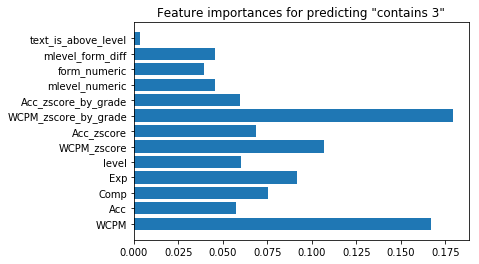

In [133]:
plt.title('Feature importances for predicting "contains 3"')
plt.barh(X_train.columns, contains_3_clf.feature_importances_)